In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 05: Shapley Interactions
Use the trained base model to explore interaction measures.  Shapley.  Do:
  * Get interactions from the SHAP package
  * Summarize 2 way interaction strength
  * Selected 1-way plots & selected analysis

*This script takes about 3 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import warnings
import time
import scipy
import random
from IPython.display import Image

In [3]:
import shap

In [4]:
from interactions_package.interactions_package import ip_plot
ip_plot.plot_defaults()

## Import Data

##### Predictors

In [5]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - use sample of training data

In [6]:
# Get the training data.  Reindex for simplicity with concat/merge.
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) \
    .reset_index(drop=True)

##### Model

In [7]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [8]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

##### Friedman's H Scores

In [9]:
h_comb = pd.read_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'))

In [10]:
# Make a table to preserve sort order - map opposite order cases
h_map = h_comb[['feat_2', 'feat_1', 'feat_1', 'feat_2']] \
    .set_axis(['feat_1', 'feat_2', 'feat_1_map', 'feat_2_map'], axis=1)

## Shapley Interactions

##### Create Explainer (Default Foil)

In [11]:
explainer = shap.TreeExplainer(base_model, feature_names=predictor_features)

In [12]:
print(explainer.expected_value) 

[-1.55058561]


##### Get SHAP interactions

In [13]:
t_init = time.process_time()
shap_interactions =  explainer.shap_interaction_values(train_samp_df[predictor_features])
total_time = time.process_time() - t_init

In [14]:
shap_interactions.shape

(100000, 18, 18)

In [15]:
type(shap_interactions)

numpy.ndarray

In [16]:
with open(Path(setup.temp_path).joinpath('05_DATA_shapley_array.pkl'), 'wb') as fo:
    pickle.dump(shap_interactions, fo)

## Mean Absolute Interactions

In [17]:
# Calculate mean abs value for SHAP data

In [18]:
abs_mat = np.array([np.abs(m) for m in shap_interactions])

In [19]:
abs_mean_mat = np.mean(abs_mat, axis=0)

In [20]:
np.shape(abs_mean_mat)

(18, 18)

In [21]:
# Convert to data frame
abs_mean_df = pd.DataFrame(abs_mean_mat,
                           index=predictor_features,
                           columns=predictor_features)

In [22]:
# Fill NAs in the lower triangle of the matrix to make values unique
abs_mean_df = abs_mean_df \
        .where(np.triu(np.ones(abs_mean_df.shape)).astype('bool'))

In [23]:
# Convert to long format.  Set NAs to diagnoal elements
abs_mean_df = abs_mean_df \
    .melt(ignore_index=False, var_name='feat_2', value_name='shap_mean_abs') \
    .reset_index() \
    .rename(columns={'index':'feat_1'}) \
    .dropna()

In [24]:
# Set correct feature order for plots
abs_mean_df = abs_mean_df.merge(h_map, on=['feat_1', 'feat_2'], how='left')

In [25]:
abs_mean_df['feat_1'] = abs_mean_df['feat_1'] \
    .where(abs_mean_df['feat_1_map'].isna(),
           abs_mean_df['feat_1_map'])
abs_mean_df['feat_2'] = abs_mean_df['feat_2'] \
    .where(abs_mean_df['feat_2_map'].isna(),
           abs_mean_df['feat_2_map'])

In [26]:
abs_mean_df = abs_mean_df \
    .drop(columns=['feat_1_map', 'feat_2_map'], errors='ignore') \
    .sort_values('shap_mean_abs', ascending=False)

In [27]:
abs_mean_df.head(10)

,feat_1,feat_2,shap_mean_abs
5,int_rate,int_rate,0.520283
2,term,term,0.143072
35,sec_app_fico_range_low,sec_app_fico_range_low,0.090230
14,annual_inc,annual_inc,0.087196
77,mort_acc,mort_acc,0.061039
0,loan_amnt,loan_amnt,0.058586
65,num_actv_bc_tl,num_actv_bc_tl,0.049945
119,home_ownership__MORTGAGE,home_ownership__MORTGAGE,0.048561
135,home_ownership__RENT,home_ownership__RENT,0.046593
44,open_acc,open_acc,0.041777


The top values are all main effects.  Plot interactions first

In [28]:
abs_mean_df['label'] = np.where(abs_mean_df['feat_1'] == abs_mean_df['feat_2'],
                                abs_mean_df['feat_1'],
                                abs_mean_df['feat_1'] + ':' + abs_mean_df['feat_2'])

In [29]:
abs_mean_df.to_csv(Path(setup.temp_path).joinpath('05_DATA_shap_mean_abs.csv'),
                   index=False)

##### Interactions plots

In [30]:
shap_int_sum = abs_mean_df[abs_mean_df['feat_1'] != abs_mean_df['feat_2']].copy()

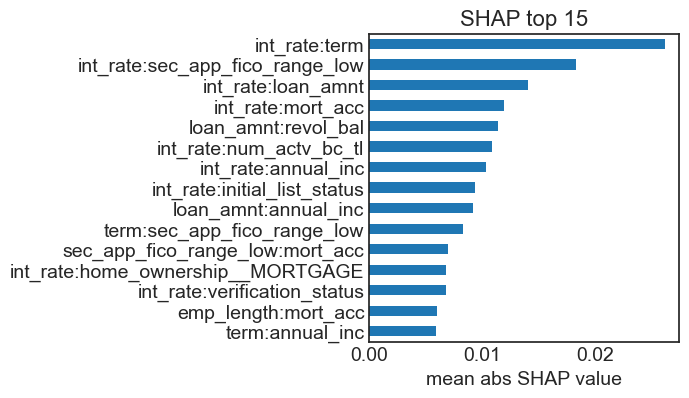

In [31]:
fig = ip_plot.plot_basic_bar(shap_int_sum, 'shap_mean_abs',
                           label='label', n_bars=15, figsize=(4,4),
                            title='SHAP top 15', ylabel='mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_shapley_pairs_all.png'),
            bbox_inches='tight')

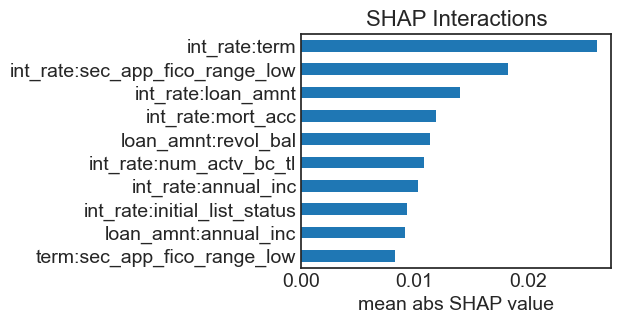

In [32]:
fig = ip_plot.plot_basic_bar(shap_int_sum, 'shap_mean_abs',
                           label='label',title='SHAP Interactions',
                           ylabel='mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_shapley_pairs_all_top_10.png'),
            bbox_inches='tight')

## SHAP Main Effects

In [33]:
shap_main_eff = abs_mean_df[abs_mean_df['feat_1'] ==
                  abs_mean_df['feat_2']] 

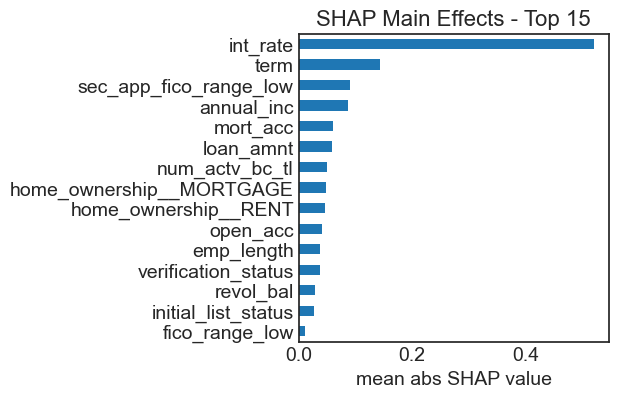

In [34]:
fig = ip_plot.plot_basic_bar(shap_main_eff, 'shap_mean_abs',
                           label='label', n_bars=15, figsize=(4,4),
                            title='SHAP Main Effects - Top 15', 
                           ylabel='mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_shapley_main_effects.png'),
            bbox_inches='tight')

## SHAP Global
Combined effect of interaction and main effects.

In [35]:
# Sum rows of each sub-matrix, then absolute value
row_sum_abs = np.array([np.abs(np.sum(m, axis=1)) for m in shap_interactions])

In [36]:
row_sum_abs.shape

(100000, 18)

In [37]:
# Mean values
mean_abs_overall = np.mean(row_sum_abs, axis=0)
mean_abs_overall.shape

(18,)

In [38]:
len(mean_abs_overall.tolist())

18

In [39]:
mean_abs_overall_df = pd.DataFrame({'feature': predictor_features,
                                   'shap_mean_abs': mean_abs_overall}) \
    .sort_values('shap_mean_abs', ascending=False)

In [40]:
mean_abs_overall_df.to_csv(Path(setup.temp_path).joinpath('05_DATA_shap_overall.csv'),
                   index=False)

In [41]:
mean_abs_overall_df.tail(10)


,feature,shap_mean_abs
15,home_ownership__RENT,0.045236
8,open_acc,0.043312
3,emp_length,0.038418
5,verification_status,0.035138
13,revol_bal,0.027650
9,initial_list_status,0.027334
6,fico_range_low,0.012489
12,pub_rec,0.006061
16,home_ownership__OWN,0.000000
17,home_ownership__ZZ_OTHER,0.000000


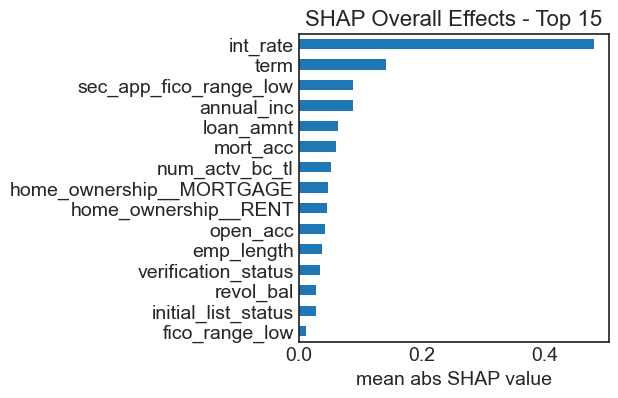

In [42]:
fig = ip_plot.plot_basic_bar(mean_abs_overall_df, 'shap_mean_abs',
                           label='feature', n_bars=15, figsize=(4,4),
                            title='SHAP Overall Effects - Top 15', 
                           ylabel='mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_shapley_overall_effects.png'),
            bbox_inches='tight')

## SHAP Dependence Plots
Create SHAP dependence plots to illustrate interactions and main effects.

##### Interactions
I start with the default SHAP package dependence plots

In [43]:
# Save plots in a folder
shap_int_dep_folder = Path(setup.temp_path) \
    .joinpath('05_PLOT_SHAP_DEP_INT')

In [44]:
shap_int_dep_folder.mkdir(parents=True, exist_ok=True)

In [45]:
# List of interactions to plot
int_features = [(h.feat_1, h.feat_2) for _, h in h_comb.iterrows()]

In [46]:
%%capture
[ip_plot.shap_dependence_plot(shap_interactions, train_samp_df[predictor_features],
                          f, title='features', title_prefix = 'SHAP - ',
                          y_label= 'SHAP interaction value',
                           output_path = shap_int_dep_folder \
                              .joinpath('__'.join(['plot_shap_dep'] + list(f)))) \
     for f in int_features]

##### Main effects

In [47]:
# Save plots in a folder
shap_main_dep_folder = Path(setup.temp_path) \
    .joinpath('05_PLOT_SHAP_DEP_MAIN')

In [48]:
shap_main_dep_folder.mkdir(parents=True, exist_ok=True)

In [49]:
import importlib
importlib.reload(ip_plot)

<module 'interactions_package.interactions_package.ip_plot' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/code/interactions_package/interactions_package/ip_plot.py'>

In [50]:
%%capture
[ip_plot.shap_dependence_plot(shap_interactions, train_samp_df[predictor_features],
                              (f,f), title='features', title_prefix = 'SHAP main effect - ',
                          y_label= 'SHAP value',
                           output_path = shap_main_dep_folder \
                              .joinpath('plot_shap_dep__' + f)) \
     for f in predictor_features]

## Selected Plots

##### Term and Interest Rate
Here, we see a dramatic difference compared to the ALE plot, with longer terms protective at high interest rates

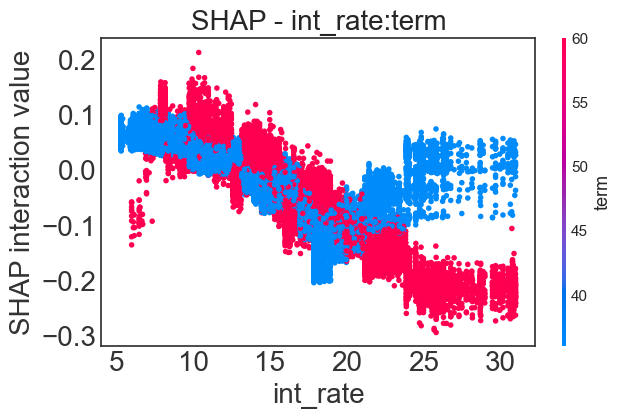

In [51]:
Image(shap_int_dep_folder.joinpath('plot_shap_dep__int_rate__term.png'))

The above plot clearly shows that a longer term decreases the risk of a high interest loan.  This is exactly the opposite of ALE.  The point where the curves diverge at interest rate ~20 is similar to ALE.

Let's look at the main effects of both features

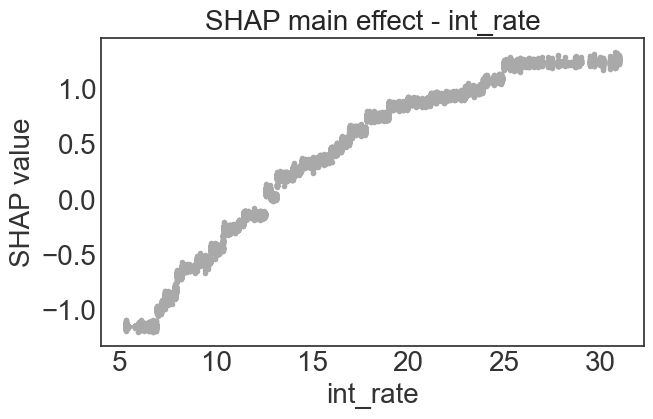

In [52]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__int_rate.png'), width=300)

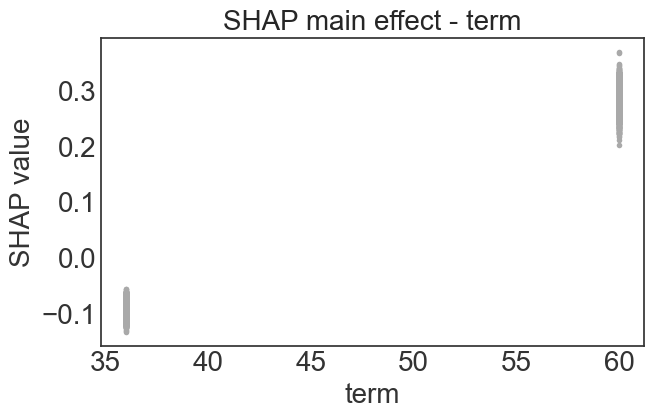

In [53]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__term.png'), width=300)

The main effects of both features are fairly intuitive.  Higher interest rates and longer terms lead to higher predicted defaults.

##### Term and Second Applicant FICO
This plot is similar to the ALE plot, with a higher risk given a long loan term and low second applicant's credit score.

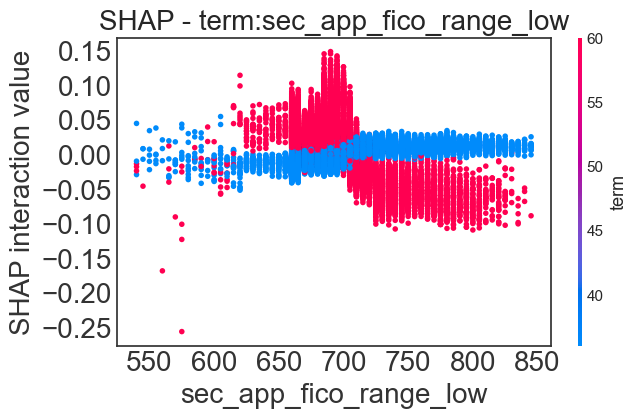

In [54]:
Image(shap_int_dep_folder.joinpath('plot_shap_dep__term__sec_app_fico_range_low.png'))

The above plot shows that the prediction is strongly affected for low 2nd FICO scores.  

We saw above that the main effect of term increases risk.  The range of values for the 1 way term plot is about 0.5, which is similar to range of values on the 2-way plot.

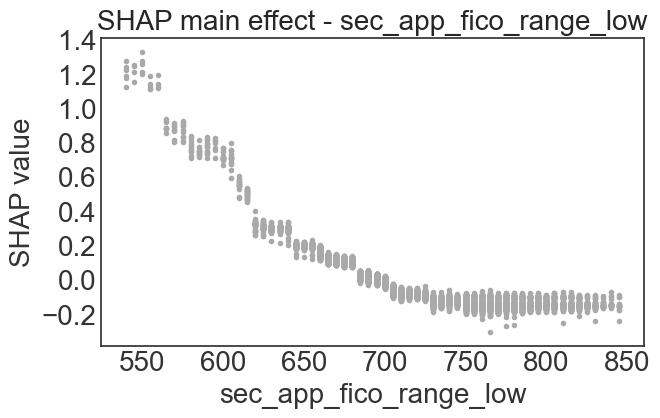

In [55]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__sec_app_fico_range_low.png'), width=300)

The main effect of the 2nd applicant's FICO is very high at low second FICO.

##### Interest Rate and Loan Amount
Again we see a fairly similar result as SHAP.  Lower loan amounts decrease the risk of high interest rates. .

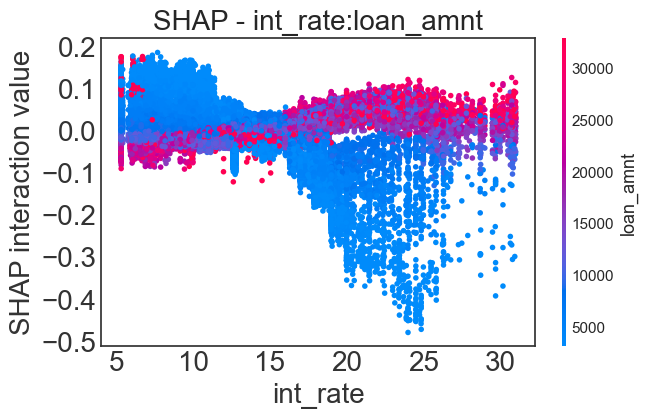

In [56]:
Image(shap_int_dep_folder.joinpath('plot_shap_dep__int_rate__loan_amnt.png'))

The interaction serves to modify cases with low interest rates. 

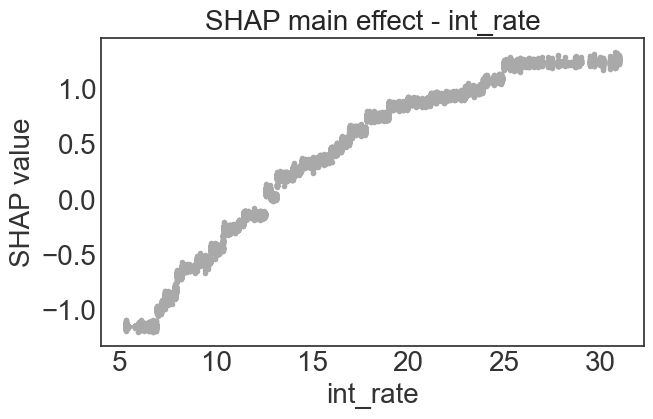

In [57]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__int_rate.png'), width=300)

As with ALE, increasing interest rates increases risk.  The range of values (>2) is large compared to the interaction shap value range (~0.8). However, ALE values show low no main effect below about ~20, follored by a rapid increase, while SHAP shows a slow rise that levels off.

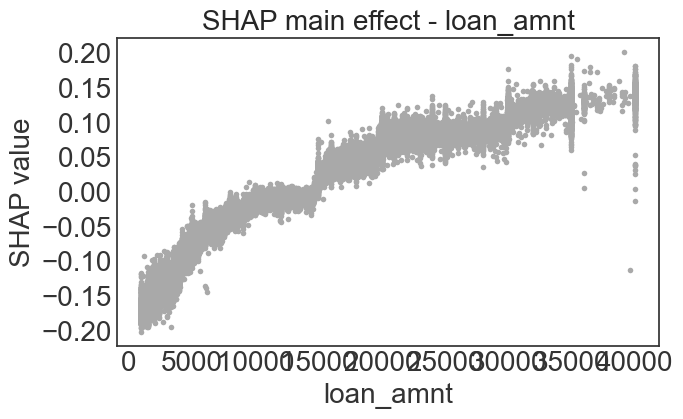

In [58]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__loan_amnt.png'), width=380)

##### Interst Rate and Income
SHAP interaction plots are ambiguous and don't seem to show strong interactions. 

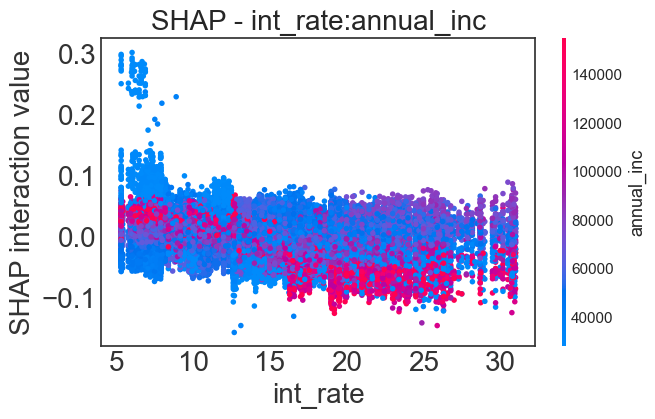

In [59]:
Image(shap_int_dep_folder.joinpath('plot_shap_dep__int_rate__annual_inc.png'))

As there is an outlier at low interest rate and low income, the y axis is shown on a log scale.  Values are small and seem to overlap, with no clear trend in a scatter plot.

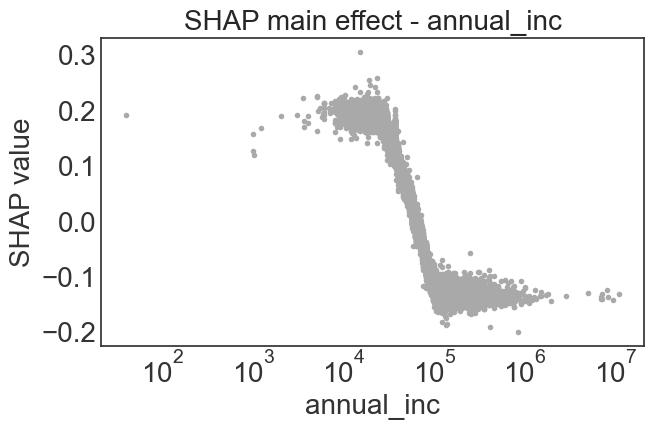

In [60]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__annual_inc.png'), width=300)

Unlike the interaction, the main effect plot is very similar to ALE.

##### Annual Income and Home Ownership Status
Compared to ALE, interactions between income and renter status are weak.

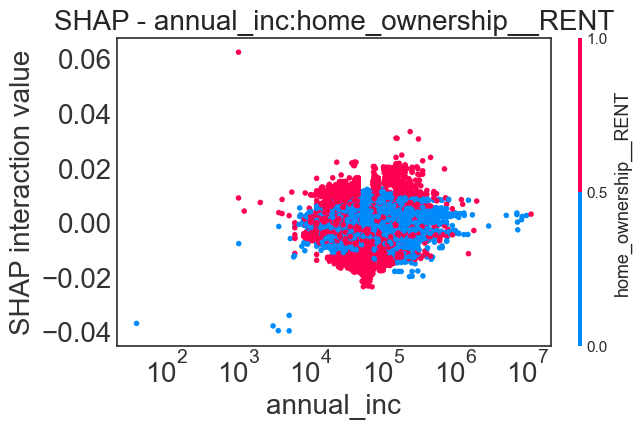

In [61]:
Image(shap_int_dep_folder.joinpath('plot_shap_dep__annual_inc__home_ownership__RENT.png'))

The interaction shows that renting is considered less risky at higher incomes!

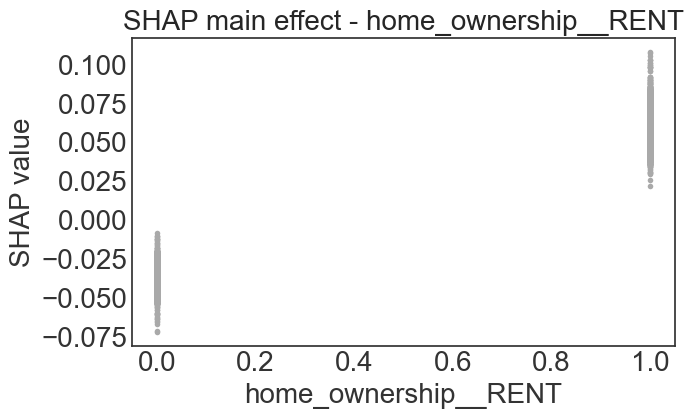

In [62]:
Image(shap_main_dep_folder.joinpath('plot_shap_dep__home_ownership__RENT.png'), width=300)

The main effect of the home ownership rent feature tends to be larger than the interaction values. As shown above, main effects for income are higher still.   

##### Term and Income
This is similar to renting and income, where at high income other risk factors become unimportant.

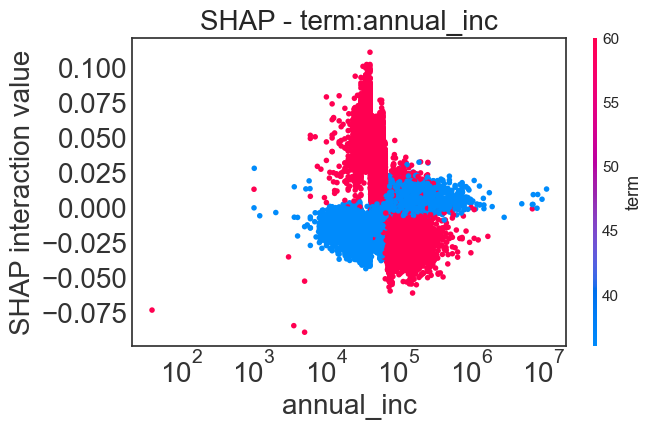

In [63]:
Image(shap_int_dep_folder.joinpath('plot_shap_dep__term__annual_inc.png'))

The interaction serves to modify cases with high interest rates.  Higher loan amounts increase the likelihood of predicting a default.

## Sample size effect - subsets
Show how the mean absolute value for an interaction value varies with sample size. Use subsets of our already measured interactions, for convenience.

In [64]:
# Function to get the mean abs interaction value for a feature pair, for a sample
def do_shap_abs_mean_sample(shap_data, feature_1, feature_2, samp_n=100):
    
    # Get the sample
    shap_subset = shap_data[random.sample(range(0, shap_data.shape[0]), samp_n)]
    
    # Get the selected mean abs
    feature_1_index = predictor_features.index(feature_1)
    feature_2_index = predictor_features.index(feature_2)
    mean_abs = np.mean(np.abs(shap_subset[:, feature_1_index, feature_2_index]))
    
    return mean_abs

In [65]:
samp_size_list = [10, 50, 100, 500, 1000]

In [66]:
# Get the data for interest rate and term
mean_abs_list = [do_shap_abs_mean_sample(shap_interactions, 'int_rate', 'term') \
    for n in samp_size_list*10]

In [67]:
mean_abs_samp_df = pd.DataFrame({'size': samp_size_list*10,
                                 'mean_abs': mean_abs_list}) \
    .groupby('size') \
    ['mean_abs'] \
    .agg(['mean', 'std'])

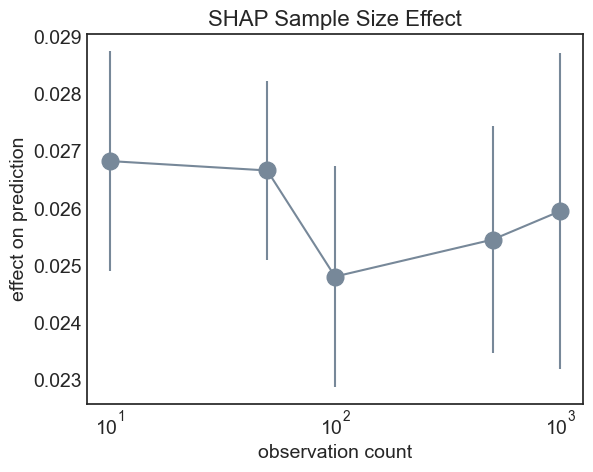

In [68]:
fig, ax = plt.subplots()
mean_abs_samp_df.plot(y='mean', yerr='std', 
                       markersize=12, style='o-', ax=ax, 
                       legend=None, color='lightslategray')
mean_abs_samp_df.plot(y='mean', markersize=12, style='o', ax=ax, 
                       legend=None, color='lightslategray')
plt.xscale('log')
plt.title("SHAP Sample Size Effect")
ax.set_xlabel('observation count')
ax.set_ylabel('effect on prediction')
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_shap_variance_with_sample_size.png'),
                  bbox_inches='tight')
plt.show()

SHAP values remain distributed because individual observations have different values.

## Interest Rate and Term

Explore standard Shapley values versus term and interest rate, as this is the interaction which is very different from ALE

##### Plot SHAP vs. interest rate and term for every feature

In [69]:
# Get the regular SHAP values (overall interaction plus main effect)
shap_overall_mat = np.sum(shap_interactions, axis=1)

In [70]:
shap_overall_mat.shape

(100000, 18)

In [71]:
# Get these as columns

In [72]:
shap_val_df = pd.DataFrame(shap_overall_mat, columns=predictor_features)
shap_val_df.columns = ['shap_' + c for c in shap_val_df.columns]

In [73]:
# Get the term and interest rate values for each point

In [74]:
shap_info_df = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                         shap_val_df], axis=1) 

In [75]:
shap_info_df['high_int_rate'] = np.where(shap_info_df['int_rate'] >=20, 1, 0)

In [76]:
shap_info_df.head(2)

,index,int_rate,term,shap_loan_amnt,shap_term,shap_int_rate,shap_emp_length,shap_annual_inc,shap_verification_status,shap_fico_range_low,...,shap_initial_list_status,shap_num_actv_bc_tl,shap_mort_acc,shap_pub_rec,shap_revol_bal,shap_home_ownership__MORTGAGE,shap_home_ownership__RENT,shap_home_ownership__OWN,shap_home_ownership__ZZ_OTHER,high_int_rate
0,0,10.91,36,-0.052108,-0.102426,-0.217064,-0.022669,-0.066335,-0.076226,0.006301,...,0.024897,0.098894,0.032067,-0.004814,0.000347,0.037750,0.065070,0.0,0.0,0
1,1,11.49,36,-0.050367,-0.087887,-0.141161,0.124275,0.000152,-0.083709,0.003907,...,0.025112,-0.066862,0.029089,0.004874,0.016819,0.049557,-0.013979,0.0,0.0,0


##### Function to do the SHAP plot vs. feature

In [77]:
# Save plots in a folder
shap_ir_term_folder = Path(setup.temp_path).joinpath('05_PLOT_SHAP_INT_RATE_x_TERM')
shap_ir_term_folder.mkdir(parents=True, exist_ok=True)

In [78]:
_ = [ip_plot.plot_shap_term_int(shap_info_df, f, 
                        outfile=shap_ir_term_folder \
                        .joinpath('plot_int_rate_x_term__' + f + '.png')) \
     for f in predictor_features]

In [79]:
# Show some plots

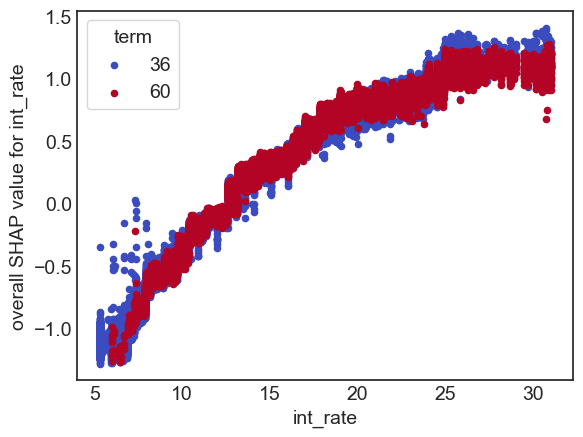

In [80]:
Image(shap_ir_term_folder.joinpath('plot_int_rate_x_term__int_rate.png'))

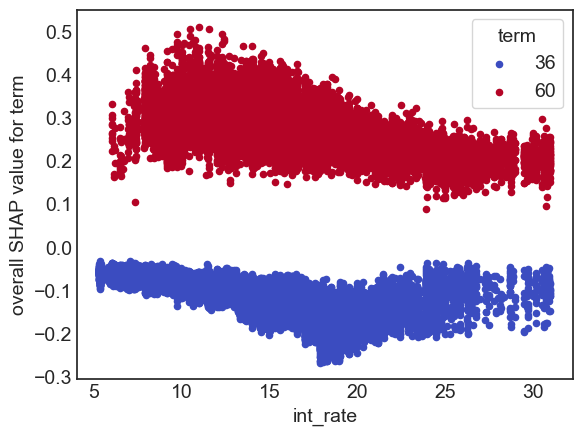

In [81]:
Image(shap_ir_term_folder.joinpath('plot_int_rate_x_term__term.png'))

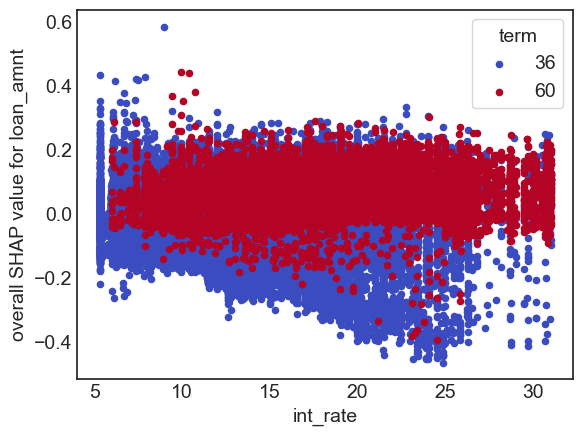

In [82]:
Image(shap_ir_term_folder.joinpath('plot_int_rate_x_term__loan_amnt.png'))

In [83]:
data = shap_info_df

In [84]:
    cmap = mpl.cm.coolwarm
    color_categories = data['term'].value_counts().index
    cnorm  = mpl.colors.Normalize(vmin=0, vmax= len(color_categories) - 1)
    color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
                  for i in range(0, len(color_categories))}

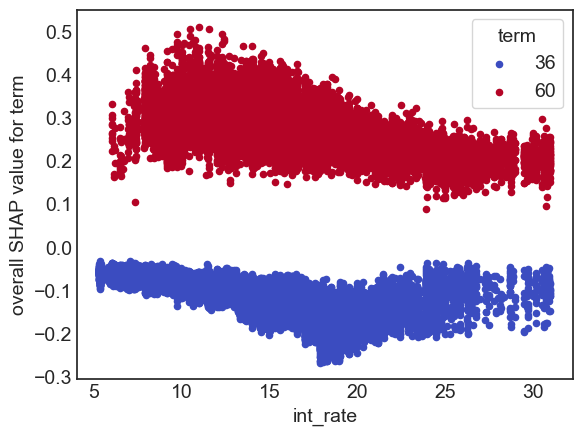

In [85]:
    # Plot
    fig, ax = plt.subplots()
    
    feature = 'term'
    plot_feature = 'shap_' + feature

    for key, group in data.groupby('term'):
        group.plot(x='int_rate', y=plot_feature, kind='scatter', ax=ax,
              color=color_dict[key], label=key)
        ax.legend(frameon=True, title='term')
        ax.set_ylabel('overall SHAP value for ' + feature)